In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import glob

Mounted at /content/drive


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Verify directory contents
import os
import glob

# Define paths
root_path = '/content/gdrive/My Drive'

# Debugging path issues
print(f"Root path contents: {os.listdir(root_path)}")


Mounted at /content/gdrive
Root path contents: ['Literacy autobiography.gdoc', 'Collaborative Grading Contract.gdoc', 'Project 1.gdoc', 'Project 1 Personal Reflection.gdoc', 'Untitled document (28).gdoc', 'Untitled document (27).gdoc', 'Revision.gdoc', 'Final Course and Conference Reflection (1).gdoc', 'Project 2 Rough Draft.gdoc', '10A Project #3.gdoc', 'Collaborative Grading Contract WCWP 10B.gdoc', 'WCWP 10B - Informal Literacy Autobiography.gdoc', 'HW 1 - Math 20D.pdf', 'WCWP10B - Project 1 Personal Reflection.gdoc', 'Math 20D - HW 1 MatLab.gdoc', 'ECE 35 - THings to know.gdoc', 'Copy of ECE 35 Lab 2.gdoc', 'Untitled drawing (3).gdraw', 'Math 20D - MATLAB HW2.gdoc', 'WCWP10B - Revision Map.gdoc', 'WCWP10b - Project 2.gdoc', 'Copy of ECE 35 Lab 1.gdoc', 'Resume (1).gdoc', 'Report.gdoc', 'Resume.gdoc', 'Lesser_Resume.gdoc', 'Copy of ECE 35 Lab 3.gdoc', 'Math 20d - MATLAB HW 3.gdoc', 'Fundamentals of Differential Equations 9th Edition.gdoc', 'WCWP 10B - Project 1.gdoc', 'Copy of ECE 3

In [ ]:
import os
import torch
import librosa
import numpy as np
import matplotlib.pyplot as plt

def pad_to_128(tensor):
    pad_amount = 128 - tensor.shape[1]
    left_pad = pad_amount // 2
    right_pad = pad_amount - left_pad
    return torch.nn.functional.pad(tensor, (left_pad, right_pad), mode='replicate')

def create_vmap(spectrogram):
    T, f = spectrogram.shape
    vmap = np.zeros_like(spectrogram)

    for t in range(T):
        if t == 0:
            vmap[t, :] = spectrogram[t + 1, :] - spectrogram[t, :]
        elif t == T - 1:
            vmap[t, :] = spectrogram[t, :] - spectrogram[t - 1, :]
        else:
            vmap[t, :] = (spectrogram[t + 1, :] - spectrogram[t - 1, :]) / 2

    return vmap

def create_amap(vmap):
    T, f = vmap.shape
    amap = np.zeros_like(vmap)

    for t in range(T):
        if t == 0:
            amap[t, :] = vmap[t + 1, :] - vmap[t, :]
        elif t == T - 1:
            amap[t, :] = vmap[t, :] - vmap[t - 1, :]
        else:
            amap[t, :] = (vmap[t + 1, :] - vmap[t - 1, :]) / 2

    return amap

def process_test_audio_file(audio_file_path, output_path, segment_length=2, step_size_in_sec=0.1):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    # Load the audio file
    y, sr = librosa.load(audio_file_path, sr=None)

    # Compute the mel spectrogram with the specified settings
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=31,
                                       fmin=1, fmax=1000, window='hann',
                                       n_mels=128, power=2.0, center=False)

    # Convert to decibels
    S_dB = librosa.power_to_db(S, ref=np.max)


    # Calculate segment and step sizes in frames

    num_segments = int(len(y) / (step_size_in_sec * sr) - (sr * 2) / (step_size_in_sec * sr))
    if num_segments >=1:
      step_size_spectrograms = S_dB.shape[1] // num_segments
    else:
      num_segments =1
      step_size_spectrograms =0

    # Initialize start frame for spectrograms
    start_frame_spectrograms = 0

    # Loop through the audio file and create segments
    for i in range(num_segments):
        # Calculate end frame of segment
        end_frame_spectrograms = start_frame_spectrograms + 128
        end_frame_spectrograms = min(end_frame_spectrograms, S_dB.shape[1])

        # Extract the segment
        segment = S_dB[:, start_frame_spectrograms:end_frame_spectrograms]



        # Pad the segment to 128x128 IF it's the only segment available
        #(file is less than 2 seconds in length)
        if (segment.shape[1] <128) and (num_segments ==1):
            pad_to_128(segment)

        # Check if the segment is too short
        if segment.shape[1] < 128:
            start_frame_spectrograms += step_size_spectrograms
            continue

        # Ensure the segment is 128x128
        if segment.shape[1] != 128:
            segment = segment[:, 1:129]

        # Create vmap and amap
        vmap = create_vmap(segment)
        amap = create_amap(vmap)

        # Combine the spectrogram, vmap, and amap into a 3x128x128 tensor
        combined_tensor = torch.tensor(np.stack([segment, vmap, amap], axis=0), dtype=torch.float32)

        # Save Spectrogram Tensor
        segment_name = f"{os.path.splitext(os.path.basename(audio_file_path))[0]}_segment_{i}"
        start_time_stamp = (start_frame_spectrograms * step_size_in_sec)
        combined_tensor_path = os.path.join(output_path, f"{segment_name}_start_{start_time_stamp:.2f}_combined.pt")
        torch.save(combined_tensor, combined_tensor_path)

        # Update start frames
        start_frame_spectrograms += step_size_spectrograms

    return num_segments

# Example usage
input_path = '/content/gdrive/My Drive/Test_Wav_Files'
output_path = "/content/gdrive/My Drive/Processed_Test_Segments"

# Iterate through all audio files in the directory
tot_segments = 0
tot_files = 0
for filename in os.listdir(input_path):
    if filename.endswith('.wav'):
        audio_file_path = os.path.join(input_path, filename)
        num_segments = process_test_audio_file(audio_file_path, output_path)
        tot_segments += num_segments
        tot_files += 1
print("Total number of segments:", tot_segments)
print("Total number of files:", tot_files)


/usr/local/lib/python3.10/dist-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


Total number of segments: 117
Total number of files: 7


In [ ]:
#Resnet implementation of it
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=2):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

def resnet18(num_classes=2):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

# Example usage:
model = resnet18(num_classes=2)
# model = model.to(device)


Labels for MCS 4.9.2024 Applesauce1_1_1_1_1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


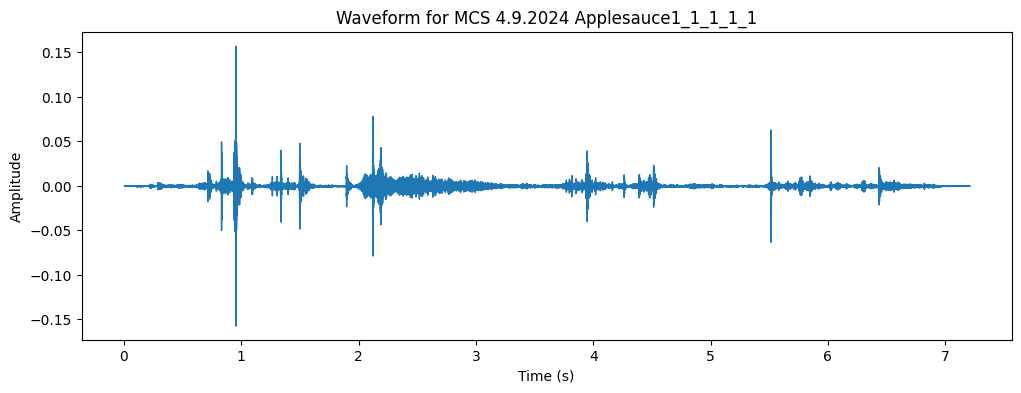

Labels for MB 4.9.2024 Applesauce2_3_2_2_3: [1, 1, 1, 1, 1]


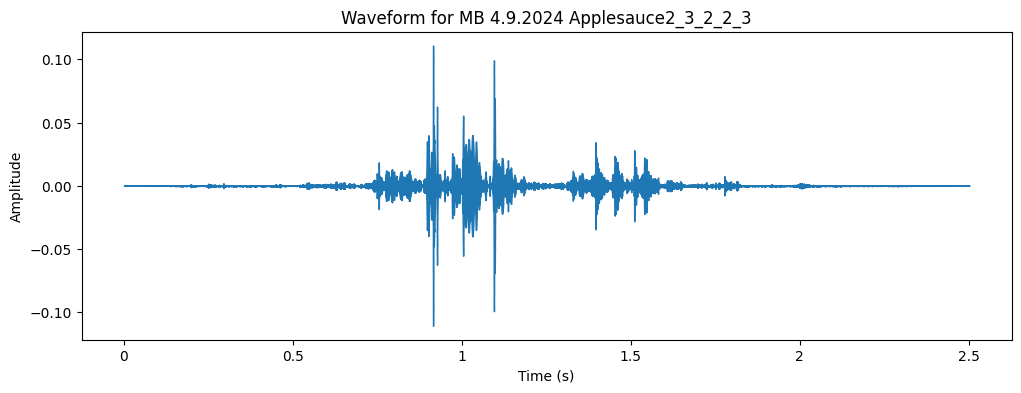

Labels for MCS 4.9.2024 Applesauce2_1_1_1_1: [1]


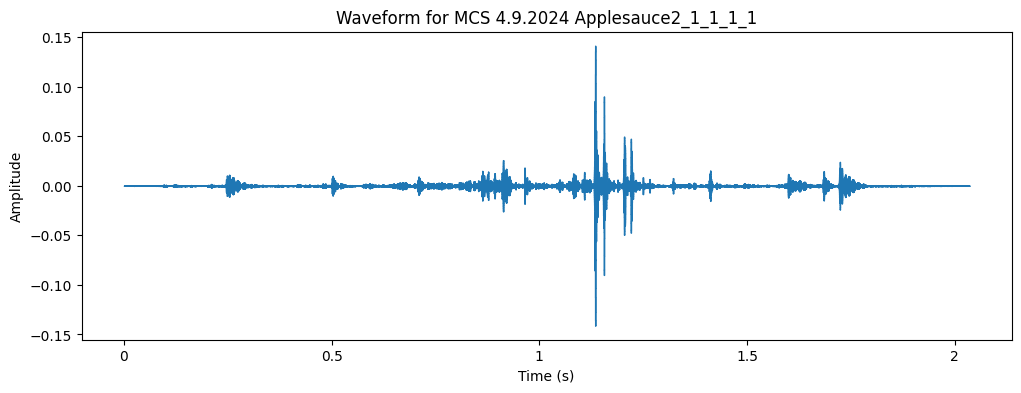

Labels for CC 4.9.2024 Applesauce1_1_2_2_1: [1]


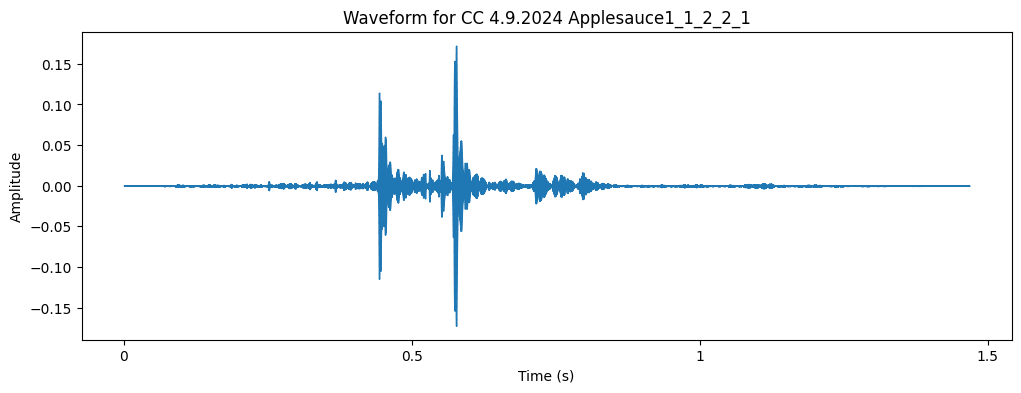

Labels for MB 4.9.2024 Applesauce1_3_2_2_3: [1, 1, 1, 1, 1, 1, 0, 0, 1]


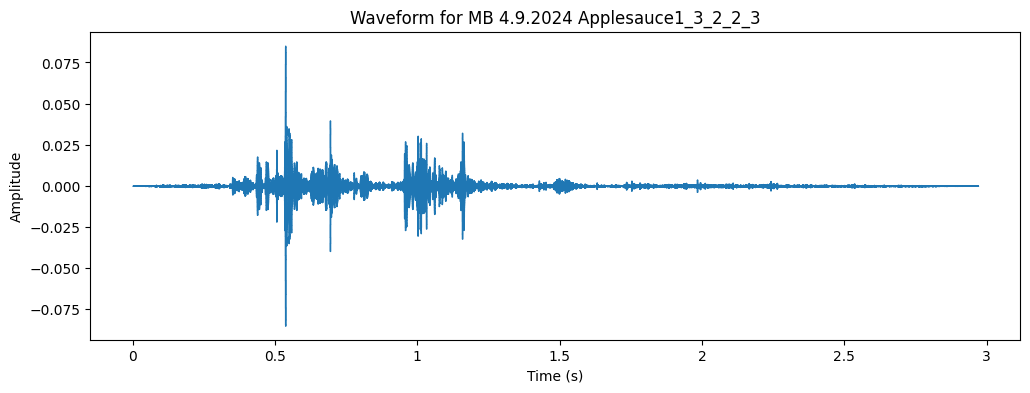

Labels for CC 4.9.2024 Applesauce2_1_2_1_1: [1, 1]


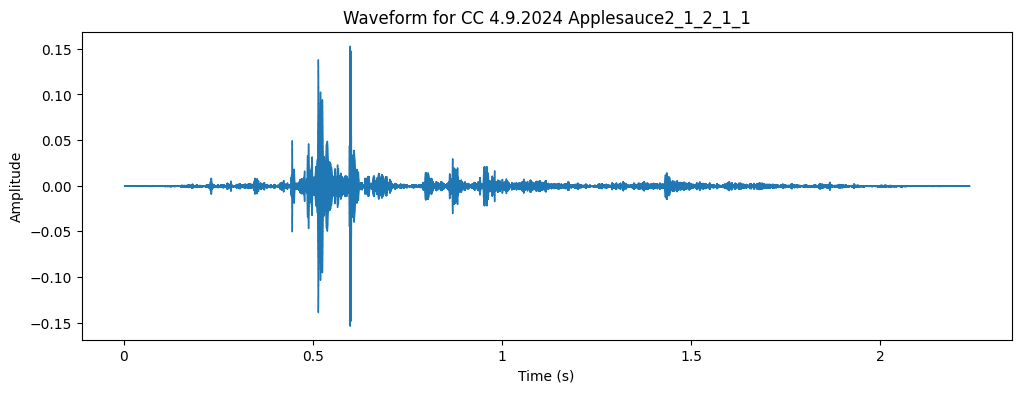

Labels for HE 4.9.2024 Applesauce1_2_1_1_1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]


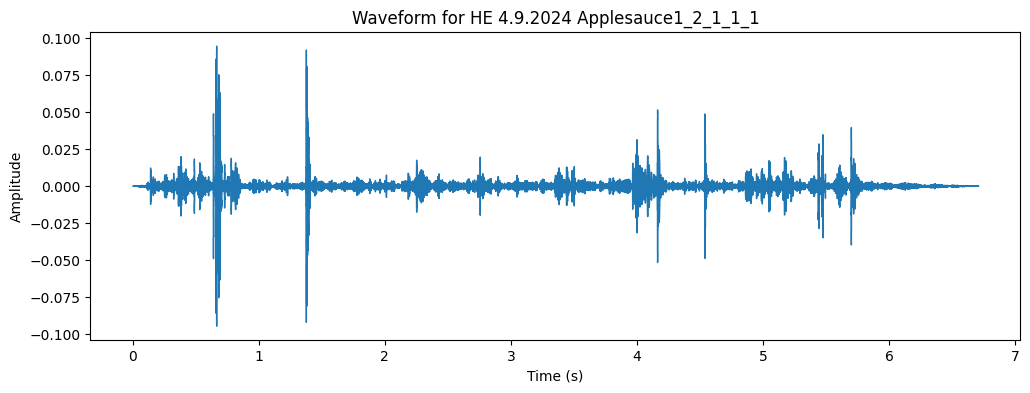

In [ ]:
import os
import glob
import torch
import librosa
import librosa.display
import matplotlib.pyplot as plt
from torchvision.models import resnet18
from torch.utils.data import DataLoader, Dataset

class CustomTensorDataset(Dataset):
    def __init__(self, tensor_paths):
        self.tensor_paths = tensor_paths

    def __len__(self):
        return len(self.tensor_paths)

    def __getitem__(self, idx):
        tensor = torch.load(self.tensor_paths[idx])
        return tensor

def load_model(model_state_path, num_classes=2):
    model = resnet18(num_classes=num_classes)
    device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
    model.load_state_dict(torch.load(model_state_path, map_location=device))
    model.to(device)
    model.eval()
    return model, device

def see_waveform_output_and_corresponding_labels(spectrogram_directory, test_wav_files_directory, model, device):
    # Get all the test wav file paths
    wav_file_paths = glob.glob(os.path.join(test_wav_files_directory, '*.wav'))

    for wav_file_path in wav_file_paths:
        # Get the base name of the wav file without extension
        base_name = os.path.splitext(os.path.basename(wav_file_path))[0]

        # Get all corresponding spectrogram paths
        spectrogram_paths = glob.glob(os.path.join(spectrogram_directory, f"{base_name}_segment_*.pt"))
        spectrogram_paths.sort()  # Ensure they are in order

        # Create DataLoader for the spectrograms
        dataset = CustomTensorDataset(spectrogram_paths)
        dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

        # Dictionary to store labels
        labels = []

        # Run the CNN on the spectrograms
        with torch.no_grad():
            for tensors in dataloader:
                tensors = tensors.to(device)
                outputs = model(tensors)
                _, preds = torch.max(outputs, 1)
                preds = preds.cpu().numpy()
                labels.extend(preds)

        # Print out the list of labels
        print(f"Labels for {base_name}: {labels}")

        # Display the waveform
        y, sr = librosa.load(wav_file_path, sr=None)
        plt.figure(figsize=(12, 4))
        librosa.display.waveshow(y, sr=sr)
        plt.title(f"Waveform for {base_name}")
        plt.xlabel("Time (s)")
        plt.ylabel("Amplitude")
        plt.show()

# Example usage
model_state_path = '/content/gdrive/My Drive/resnet18_model_state.pth'
spectrogram_directory = '/content/gdrive/My Drive/Processed_Test_Segments'
test_wav_files_directory = '/content/gdrive/My Drive/Test_Wav_Files'

# Load the model
model, device = load_model(model_state_path)

# See the waveform output and corresponding labels
see_waveform_output_and_corresponding_labels(spectrogram_directory, test_wav_files_directory, model, device)
